In [1548]:
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import sys
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
import os

In [1549]:
file_path = '../data/dgidb/embeddings/'

#emd = 'metapath2vec_'
#emd = 'node2vec_'
#emd = 'struc2vec_'
#emd = 'deepwalk_'
#emd = 'word2vec_'
emd = 'bine_'

drug_embeddings = pd.read_csv(file_path+emd+'drug_embeddings.csv', header=None, index_col=0).dropna(axis=1)
gene_embeddings = pd.read_csv(file_path+emd+'gene_embeddings.csv', header=None, index_col=0).dropna(axis=1)

In [1550]:
tt_path = '../data/dgidb/train_test/'

#ns = '/uniform'
#ns = '/feature'
ns = '/topology'


train_edge = pd.read_csv(tt_path+emd[:-1]+ns+"/train.csv")
test_edge = pd.read_csv(tt_path+emd[:-1]+ns+"/test.csv")

In [1551]:
# Function to load data from CSV and create edge indices
def load_data_and_create_edges(file_path, node_to_idx):
    df = pd.read_csv(file_path)
    edge_list = df[df['label'] == 1][['gene', 'drug']].values.tolist()
    neg_edge_list = df[df['label'] == 0][['gene', 'drug']].values.tolist()

    # Creating edge indices
    edge_index = [[node_to_idx[u], node_to_idx[v]] for u, v in edge_list]
    neg_edge_index = [[node_to_idx[u], node_to_idx[v]] for u, v in neg_edge_list]

    return torch.tensor(edge_index, dtype=torch.long).t(), torch.tensor(neg_edge_index, dtype=torch.long).t()

In [1552]:
# Ensure embeddings have the same dimensionality
assert gene_embeddings.shape[1] == drug_embeddings.shape[1], "Embeddings must have the same dimensionality"

In [1553]:
# Concatenate gene and drug embeddings
node_embeddings = torch.tensor(np.concatenate((gene_embeddings, drug_embeddings), axis=0), dtype=torch.float)

In [1554]:
# Combine unique genes and drugs from both training and testing data
unique_genes_train = set(pd.read_csv(tt_path+emd[:-1]+ns+"/train.csv")['gene'].unique())
unique_drugs_train = set(pd.read_csv(tt_path+emd[:-1]+ns+"/train.csv")['drug'].unique())
unique_genes_test = set(pd.read_csv(tt_path+emd[:-1]+ns+"/test.csv")['gene'].unique())
unique_drugs_test = set(pd.read_csv(tt_path+emd[:-1]+ns+"/test.csv")['drug'].unique())

all_genes = unique_genes_train.union(unique_genes_test)
all_drugs = unique_drugs_train.union(unique_drugs_test)

# Create a comprehensive node_to_idx mapping
node_to_idx = {node: idx for idx, node in enumerate(list(all_genes) + list(all_drugs))}

# Now load train and test data
train_edge_index, train_neg_edge_index = load_data_and_create_edges(tt_path+emd[:-1]+ns+"/train.csv", node_to_idx)
test_edge_index, test_neg_edge_index = load_data_and_create_edges(tt_path+emd[:-1]+ns+"/test.csv", node_to_idx)


In [1555]:
# Load train and test data
train_edge_index, train_neg_edge_index = load_data_and_create_edges(tt_path+emd[:-1]+ns+"/train.csv", node_to_idx)
test_edge_index, test_neg_edge_index = load_data_and_create_edges(tt_path+emd[:-1]+ns+"/test.csv", node_to_idx)

In [1556]:
# Graph construction
num_features = node_embeddings.shape[1]
data = Data(x=node_embeddings, edge_index=train_edge_index)

In [1557]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.edge_predictor = torch.nn.Linear(2 * hidden_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [1558]:
lr = 0.001
num_epoch = 1000
hc = 64

In [1559]:
model = GCN(num_features=num_features, hidden_channels=hc)

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [1560]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    node_embeddings = model(data.x, train_edge_index)
    pos_edge_features = torch.cat([node_embeddings[train_edge_index[0]], node_embeddings[train_edge_index[1]]], dim=1)
    neg_edge_features = torch.cat([node_embeddings[train_neg_edge_index[0]], node_embeddings[train_neg_edge_index[1]]], dim=1)
    all_edge_features = torch.cat([pos_edge_features, neg_edge_features], dim=0)
    pos_labels = torch.ones(pos_edge_features.size(0), dtype=torch.float)
    neg_labels = torch.zeros(neg_edge_features.size(0), dtype=torch.float)
    all_labels = torch.cat([pos_labels, neg_labels], dim=0)
    edge_scores = model.edge_predictor(all_edge_features).squeeze(1)
    loss = criterion(edge_scores, all_labels)
    loss.backward()
    optimizer.step()
    return loss.item()

In [1561]:
# Testing function
def test():
    model.eval()
    with torch.no_grad():
        node_embeddings = model(data.x, test_edge_index)
        pos_edge_features = torch.cat([node_embeddings[test_edge_index[0]], node_embeddings[test_edge_index[1]]], dim=1)
        neg_edge_features = torch.cat([node_embeddings[test_neg_edge_index[0]], node_embeddings[test_neg_edge_index[1]]], dim=1)
        all_edge_features = torch.cat([pos_edge_features, neg_edge_features], dim=0)
        pos_labels = torch.ones(pos_edge_features.size(0), dtype=torch.float)
        neg_labels = torch.zeros(neg_edge_features.size(0), dtype=torch.float)
        all_labels = torch.cat([pos_labels, neg_labels], dim=0)
        edge_scores = model.edge_predictor(all_edge_features).squeeze(1)
        loss = criterion(edge_scores, all_labels)
        return loss.item(), edge_scores, all_labels

In [1562]:
# Train and test the model
train_losses = []
test_losses = []
for epoch in tqdm(range(num_epoch)):
    train_loss = train()
    test_loss, test_scores, test_labels = test()
    train_losses.append(train_loss)
    test_losses.append(test_loss)

100%|██████████| 1000/1000 [00:53<00:00, 18.77it/s]


In [1563]:
test_loss, test_scores, test_labels = test()

In [1564]:
# Directory for saving results
res_path = '../res/gcn/' + emd[:-1] + ns 
os.makedirs(res_path, exist_ok=True)

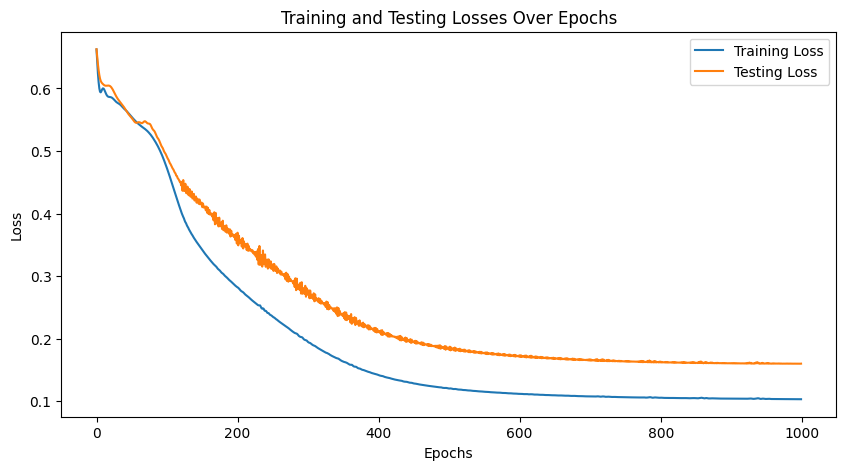

In [1565]:
# Plot the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses Over Epochs')
plt.legend()

plots_file_path = res_path + '/loss.png'
plt.savefig(plots_file_path)
plt.show()

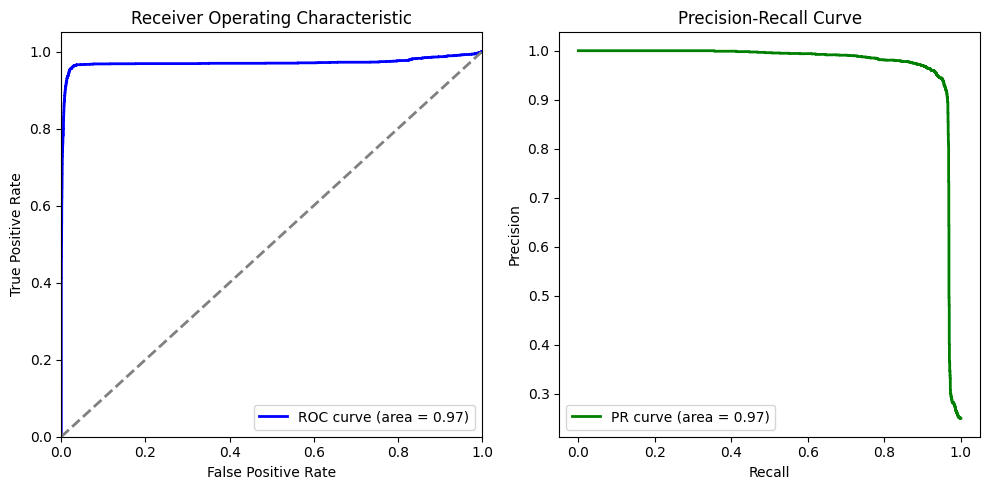

In [1566]:
# Function to evaluate the model and calculate metrics
def evaluate_model():
    model.eval()
    with torch.no_grad():
        node_embeddings = model(data.x, test_edge_index)
        pos_edge_features = torch.cat([node_embeddings[test_edge_index[0]], node_embeddings[test_edge_index[1]]], dim=1)
        neg_edge_features = torch.cat([node_embeddings[test_neg_edge_index[0]], node_embeddings[test_neg_edge_index[1]]], dim=1)
        all_edge_features = torch.cat([pos_edge_features, neg_edge_features], dim=0)
        edge_scores = model.edge_predictor(all_edge_features).squeeze(1)
        edge_scores = torch.sigmoid(edge_scores).cpu().numpy()
        all_labels = torch.cat([torch.ones(pos_edge_features.size(0)), torch.zeros(neg_edge_features.size(0))], dim=0).cpu().numpy()

        y_pred = (edge_scores >= 0.5).astype(int)
        accuracy = accuracy_score(all_labels, y_pred)
        precision_scr = precision_score(all_labels, y_pred)
        recall_scr = recall_score(all_labels, y_pred)
        f1 = f1_score(all_labels, y_pred)

        fpr, tpr, _ = roc_curve(all_labels, edge_scores)
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve(all_labels, edge_scores)
        pr_auc = auc(recall, precision)

        return accuracy, precision_scr, recall_scr, f1, fpr, tpr, roc_auc, precision, recall, pr_auc

# Evaluate the model
accuracy, precision_scr, recall_scr, f1, fpr, tpr, roc_auc, precision, recall, pr_auc = evaluate_model()

# Plot and save ROC and PRC curves
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')

plt.tight_layout()
plots_file_path = res_path + '/plot.png'
plt.savefig(plots_file_path)
plt.show()

# Save metrics to file
metrics = {
    'Accuracy': accuracy,
    'Precision': precision_scr,
    'Recall': recall_scr,
    'F1 Score': f1,
    'AUROC': roc_auc,
    'AUPRC': pr_auc
}
metrics_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['Value'])
metrics_file_path = res_path + '/metrics.csv'
metrics_df.to_csv(metrics_file_path)

# Save ROC and PRC data to CSV
roc_df = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
roc_df.to_csv(res_path + '/roc.csv', index=None)

prc_df = pd.DataFrame({'precision': precision, 'recall': recall})
prc_df.to_csv(res_path + '/prc.csv', index=None)